# Classification

Nous sommes souvent confrontés au défi d'attribuer aux objets la bonne étiquette en fonction d'un ensemble prédéfini de classes :

- Est-ce un animal dans une image est un chien ou un chat ? Un échantillon de tissu donné est-il révélateur d'un cancer, ou est-il bénin ?
- Est-ce une transaction financière quelcone est une fraude ou non ?

La classification est le problème de prédire la bonne étiquette (ou catégorie) _label_ pour une observation donnée. La tâche diffère de la régression en ce que les étiquettes sont des entités discrètes, et non des valeurs de fonctions continues.

On peut penser qu'essayer de choisir la bonne réponse parmi deux possibilités (seulement deux choix) peut sembler plus facile que de prédire des quantités ouvertes (un large éventail de possibilités), mais il est aussi beaucoup plus facile faire des erreurs.

## Un aperçu de la classification

Tout comme dans la régression, dans de la classification, nous avons un ensemble d'observations d'entraînement $\left(x_{1}, y_{1}\right), \ldots,\left(x_{n}, y_{n}\right)$ que nous pouvons utiliser pour construire un classificateur. Nous voulons que notre classificateur soit performant non seulement sur les données d'entraînement, mais aussi sur les observations de test qui n'ont pas été utilisées pour entraîner le classificateur.

Illustrerons le concept de classification en utilisant l'ensemble de données simulées `Default`. Nous cherchons à prédire si un individu sera en défaut de paiement sur sa carte de crédit, sur la base de son revenu annuel et de son solde mensuel de carte de crédit.

L'ensemble de données est présenté à la figure ci-dessous. Nous avons tracé le revenu annuel `income` et le solde mensuel de la carte de crédit `balance` pour un sous-ensemble de 10 000 personnes. Le graphique de gauche de la figure ci-dessous affiche en orange les personnes qui ont fait défaut de paiement au cours d'un mois donné, et en bleu celles qui ne l'ont pas fait (le taux de défaut global est d'environ 3 %, nous n'avons donc tracé qu'une fraction des personnes qui n'ont pas fait défaut). Il semble que les personnes qui ont manqué à leurs obligations ont eu tendance à avoir des soldes de cartes de crédit plus élevés que celles qui n'ont pas payé leur dû. Dans le panneau de droite de la figure 4.1, deux paires de boxplots sont présentées. La première montre la distribution des soldes `balance` répartis par la variable binaire `default`; la seconde est un graphique similaire pour les revenus `income`. Dans cette section, nous apprenons à construire un modèle permettant de prédire la valeur `default` $(Y)$ pour une valeur donnée du solde `balance` $\left(X_{1}\right)$ et du revenu `income` $\left(X_{2}\right)$. Comme $Y$ n'est pas quantitatif, le modèle de régression linéaire simple n'est pas approprié.

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
df = pd.read_excel('Default.xlsx')

# Note : factorize() renvoie deux objets : un tableau d'étiquettes et un tableau de valeurs uniques.
# Nous ne sommes intéressés que par le premier objet. 
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]
df.head(3)

Unnamed: 0 default student      balance        income  default2  student2
0           1      No      No   729.526495  44361.625074         0         0
1           2      No     Yes   817.180407  12106.134700         0         1
2           3      No      No  1073.549164  31767.138947         0         0

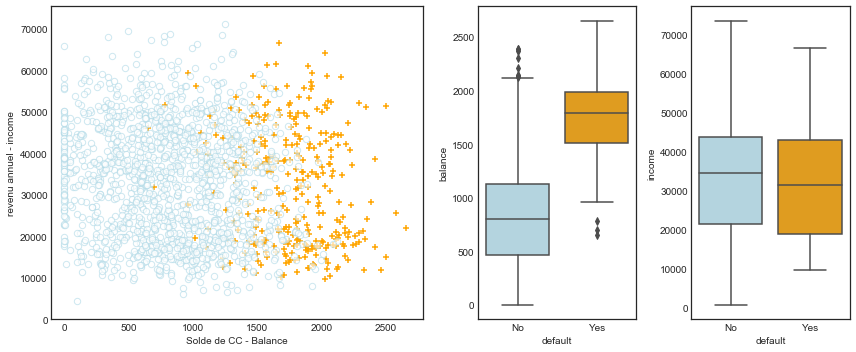

In [8]:
fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# On prend une fraction des échantillons dont la valeur cible (par défaut) est "non".
df_no = df[df.default2 == 0].sample(frac=0.15)
# Prendre tous les échantillons dont la valeur cible est "oui".
df_yes = df[df.default2 == 1]
df_ = df_no.append(df_yes)

ax1.scatter(df_[df_.default == 'Yes'].balance, df_[df_.default == 'Yes'].income, s=40, c='orange', marker='+',
            linewidths=1)
ax1.scatter(df_[df_.default == 'No'].balance, df_[df_.default == 'No'].income, s=40, marker='o', linewidths='1',
            edgecolors='lightblue', facecolors='white', alpha=.6)

ax1.set_ylim(ymin=0)
ax1.set_ylabel('revenu annuel - income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Solde de CC - Balance')

c_palette = {'No':'lightblue', 'Yes':'orange'}
sns.boxplot('default', 'balance', data=df, orient='v', ax=ax2, palette=c_palette)
sns.boxplot('default', 'income', data=df, orient='v', ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())

(content:references_lg_reg)=
## Régression logistique

Dans notre ensemble de données, la variable réponse `default` possède deux catégories, `Yes` ou `No`. Plutôt que de modéliser directement cette réponse $Y$, la régression logistique modélise la probabilité que $Y$ appartienne à une catégorie particulière.

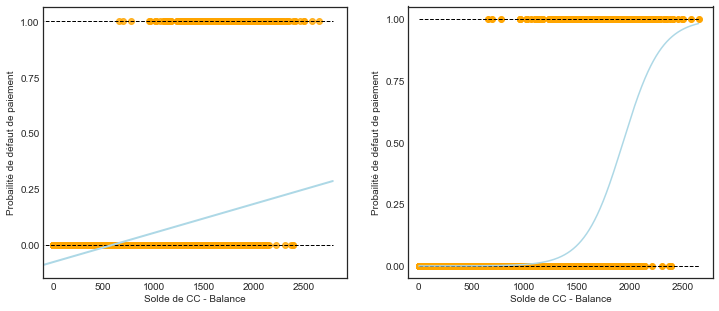

In [9]:
X_train = df.balance.values.reshape(-1,1) 
y = df.default2
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train,y)
prob = clf.predict_proba(X_test)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

sns.regplot(df.balance, df.default2, order=1, ci=None,
            scatter_kws={'color':'orange'},
            line_kws={'color':'lightblue', 'lw':2}, ax=ax1)
 
ax2.scatter(X_train, y, color='orange')
ax2.plot(X_test, prob[:,1], color='lightblue')

for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.set_ylabel('Probailité de défaut de paiement')
    ax.set_xlabel('Solde de CC - Balance')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])
    ax.set_xlim(xmin=-100)

La probabilité de défaut d'un solde donné peut s'écrire:

$$\operatorname{Pr}(\text{default} = \text{Yes} \mid  \text{solde} )$$

Les valeurs de $\operatorname{Pr}(\text{default} = \text{Yes} \mid  \text{balance} )$, que nous abrégeons $p(\text{solde})$, seront comprises entre 0 et 1. Ensuite, pour toute valeur donnée de balance, une prédiction peut être faite pour la valeur `default`. Par exemple, on peut prédire la valeur par `default=Yes` pour tout individu pour lequel  $p(\text{solde})>0.5$. Par ailleurs, si une entreprise émettrice de carte de crédit souhaite être prudente dans la prédiction des personnes qui risquent de se trouver en situation de défaut de paimenet, elle peut choisir d'utiliser un seuil inférieur, tel que  $p(\text{solde})>0.1$.

## Le modèle logistique

Comment modéliser la relation entre $p(X)=\operatorname{Pr}(Y=1 \mid X)$ et $X$ ? (Par commodité, nous utilisons le codage binaire $0/1$ pour la réponse). Dans la section précédente, nous avons parlé de l'utilisation d'un modèle de régression linéaire pour représenter ces probabilités :

```{math}
:label: regr_lineaire_simple
p(X)=\beta_{0}+\beta_{1} X
```

Si nous utilisons cette approche pour prédire `default=Yes` en utilisant le solde `balance`, nous obtenons le modèle présenté dans le graphique de gauche de la figure sur les salaire  de la section précédente ({ref}`content:references_lg_reg`). Nous voyons ici le problème que pose cette approche : pour des soldes proches de zéro, nous prédisons une probabilité de défaut négative.

Ces prédictions ne sont pas justes, car bien entendu la véritable probabilité de défaut, quel que soit le solde de la carte de crédit, doit se situer entre 0 et 1.

Pour éviter ce problème, nous devons modéliser $p(X)$ en utilisant une fonction qui donne des résultats entre $0$ et $1$ pour toutes les valeurs de $X$. De nombreuses fonctions répondent à cette description. Dans la régression logistique, nous utilisons la fonction logistique,

```{math}
:label: logistic
p(X)=\frac{e^{\beta_{0}+\beta_{1} X}}{1+e^{\beta_{0}+\beta_{1} X}}
```

Pour ajuster le modèle  {eq}`logistic`, nous utilisons une méthode appelée maximum de vraisemblance

Après un peu de manipulation algébrique de {eq}`logistic`, nous trouvons:

$$\frac{p(X)}{1-p(X)}=e^{\beta_{0}+\beta_{1} X}$$

La quantité $p(X) /[1-p(X)]$ est appelée _odds_, et peut prendre n'importe quelle valeur entre 0 et $\infty$.

En prenant le logarithme des deux côtés de {eq}`log-logistic`, on arrive à:

```{math}
:label: log-logistic
\log \left(\frac{p(X)}{1-p(X)}\right)=\beta_{0}+\beta_{1} X
```

Le côté gauche est appelé log-odds ou _logit_. Nous pouvons remarquer que le modèle de régression logistique {eq}`logistic` a un logit qui est linéaire en $X$.

## Estimation des coefficients de régression

Les coefficients $\beta_{0}$ et $\beta_{1}$ dans {eq}`logistic` sont inconnus, et doivent être estimés à partir des données d’entraînement.

Dans les sections précédentes, nous avons utilisé l'approche des moindres carrés pour estimer les coefficients de régression linéaire inconnus. Bien que nous puissions utiliser les moindres carrés (non linéaires) pour ajuster le modèle {eq}`log-logistic`, la méthode maximum de vraisemblance est préférable dans ce cas, car elle a de meilleures propriétés statistiques.

L'intuition de base derrière l'utilisation du maximum de vraisemblance pour ajuster un modèle de régression logistique est la suivante : nous cherchons des estimations pour $\hat{\beta_{0}}$ et $\hat{\beta_{1}}$ de telle sorte que la probabilité de défaut prédite $\hat{p}\left(x_{i}\right)$ pour chaque individu, en utilisant {eq}`logistic`, corresponde un chiffre proche de $1$ pour tous les individus qui ont fait défaut, et un chiffre proche de $0$ pour tous les individus qui n'ont pas fait défaut. Cette intuition peut être formalisée à l'aide d'une équation mathématique appelée fonction de vraisemblance :

$$\ell\left(\beta_{0}, \beta_{1}\right)=\prod_{i: y_{i}=1} p\left(x_{i}\right) \prod_{i^{\prime}: y_{i^{\prime}}=0}\left(1-p\left(x_{i^{\prime}}\right)\right)$$

Les estimations $\hat{\beta}_{0}$ et $\hat{\beta}_{1}$ sont calculés pour maximiser cette fonction de vraisemblance.

Les modèles de régression logistique et autres peuvent être facilement ajustés à l'aide d'un logiciel statistique tel que R, et nous n'avons donc pas besoin de nous préoccuper des détails de la procédure d'ajustement du maximum de vraisemblance.

Le code `Python` présente les estimations des coefficients et les informations connexes qui résultent de l'ajustement d'un modèle de régression logistique sur les données `default` afin de prédire la probabilité de `default=Yes` en utilisant le solde `balance` comme variable explicative.x

Le code `Python` présente les estimations des coefficients et les informations connexes qui résultent de l'ajustement d'un modèle de régression logistique sur les données `default` afin de prédire la probabilité de `default=Yes` en utilisant le solde `balance` comme variable explicative. On voit que $\hat{\beta}_{1}=0.005499$; cela indique qu'une augmentation du solde est associée à une augmentation de la probabilité de défaut de paiement. Pour être précis, une augmentation d'une unité du solde est associée à une augmentation de 0,0055 unité du logarithme de la probabilité de défaut.

In [10]:
clf = skl_lm.LogisticRegression(solver='newton-cg')
X_train = df.balance.values.reshape(-1,1)
clf.fit(X_train,y)
print(clf)
print('classes: ',clf.classes_)
print('coefficients: ',clf.coef_)
print('intercept :', clf.intercept_)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
classes:  [0 1]
coefficients:  [[0.00549891]]
intercept : [-10.65132226]


In [12]:
import statsmodels.api as smapi

In [13]:
X_train = sm.add_constant(df.balance)
est = smapi.Logit(y.ravel(), X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


Coef.  Std.Err.          z          P>|z|     [0.025    0.975]
const   -10.651331  0.361169 -29.491287  3.723665e-191 -11.359208 -9.943453
balance   0.005499  0.000220  24.952404  2.010855e-137   0.005067  0.005931

## Prédictions

Une fois les coefficients estimés, il est facile de calculer la probabilité de défaut de paiment pour un solde de carte de crédit donné. Par exemple, en utilisant les estimations des coefficients données dans le tableau précédent, nous prévoyons que la probabilité de défaut de paiment pour une personne ayant un solde de `1000 $` est

$$\hat{p}(X)=\frac{e^{\hat{\beta}_{0}+\hat{\beta}_{1} X}}{1+e^{\hat{\beta}_{0}+\hat{\beta}_{1} X}}=\frac{e^{-10.6513+0.0055 \times 1,000}}{1+e^{-10.6513+0.0055 \times 1,000}}=0.00576$$

qui est inférieure à 1 %. En revanche, la probabilité de défaut de paiment prédite pour un individu disposant d'un solde de 2 000 dollars est beaucoup plus élevée, et équivaut à 0,586 ou 58,6 %.

Nous examinons maintenant le problème de la prédiction d'une réponse binaire à l'aide de prédicteurs multiples. Nous pouvons généraliser {eq}`log-logistic` comme suit :

$$\log \left(\frac{p(X)}{1-p(X)}\right)=\beta_{0}+\beta_{1} X_{1}+\cdots+\beta_{p} X_{p}$$

où $X=\left(X_{1}, \ldots, X_{p}\right)$ sont $p$ prédicteurs. L'équation 4.6 peut être réécrite comme suit

```{math}
:label: log-logistic-gener
p(X)=\frac{e^{\beta_{0}+\beta_{1} X_{1}+\cdots+\beta_{p} X_{p}}}{1+e^{\beta_{0}+\beta_{1} X_{1}+\cdots+\beta_{p} X_{p}}}
```

In [16]:
X_train = sm.add_constant(df[['balance', 'income', 'student2']])
est = smapi.Logit(y, X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


Coef.  Std.Err.          z          P>|z|     [0.025    0.975]
const    -10.869045  0.492273 -22.079320  4.995499e-108 -11.833882 -9.904209
balance    0.005737  0.000232  24.736506  4.331521e-135   0.005282  0.006191
income     0.000003  0.000008   0.369808   7.115254e-01  -0.000013  0.000019
student2  -0.646776  0.236257  -2.737595   6.189022e-03  -1.109831 -0.183721

En substituant des estimations aux coefficients de régression du tableau ci-dessus à {eq}`log-logistic-gener`, nous pouvons faire des prédictions. Par exemple, un étudiant ayant un solde de carte de crédit de 1 500 et un revenu de 40 000 a une probabilité de défaut de paiment estimée à

$$\hat{p}(X)=\frac{e^{-10.869+0.00574 \times 1,500+0.003 \times 40-0.6468 \times 1}}{1+e^{-10.869+0.00574 \times 1,500+0.003 \times 40-0.6468 \times 1}}=0.058$$

Un non-étudiant ayant le même solde et le même revenu a une probabilité de défaillance estimée à

$$\hat{p}(X)=\frac{e^{-10.869+0.00574 \times 1,500+0.003 \times 40-0.6468 \times 0}}{1+e^{-10.869+0.00574 \times 1,500+0.003 \times 40-0.6468 \times 0}}=0.105$$